# Landslide Modeling Project for ESPIn

### This notebook is to start working on the project we chose for the ESPIn program. Our objective is to model landslide suspectibility for changes in root cohesion and ...

In [1]:
import copy
import warnings
import os

import matplotlib as mpl
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import rioxarray 
import cftime
from datetime import datetime
from tqdm import trange
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video
from pymt.models import Topography

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional
from landlab.components import BedrockLandslider  # BedrockLandslider model
from landlab.components import SpaceLargeScaleEroder  # SPACE model
from landlab.components import PriorityFloodFlowRouter

from utils import regrid_data, cal_subsurface_flow_depth, cal_safety_factor

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (5.1.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/opt/conda/lib/python3.9/site-packages/model_metadata/model_info.py:118: UserWarning: None: version string does not follow PEP440
  warnings.warn(f"{version}: version string does not follow PEP440")


In [2]:
# Set grid parameters
num_rows = 50
num_columns = 50
node_spacing = 25.0

# Instantiate model grid
grid = RasterModelGrid((num_rows, num_columns), node_spacing)
# add field ’topographic elevation’ to the grid
grid.add_zeros("node", "topographic__elevation")

# set constant random seed for consistent topographic roughness
#np.random.seed(seed=5000)

# Create initial model toporaphy:
# add topographic roughness
random_noise = (np.random.rand(len(grid.node_y)) / 1000.0)
grid["node"]["topographic__elevation"] += random_noise

#add field "soil__depth" to the grid
grid.add_zeros("node", "soil__depth")

# Set 2 meter of initial soil depth at the core nodes
grid.at_node["soil__depth"][grid.core_nodes] = 2.0  # meters

#Add a field "bedrock__elevation" to the grid
grid.add_zeros("bedrock__elevation", at="node")

#Sum soil depth and bedrock elevation to equal topographoc elevation
grid.at_node["bedrock__elevation"][:] = grid.at_node["topographic__elevation"]
grid.at_node["topographic__elevation"][:] += grid.at_node["soil__depth"]

In [3]:
# Open all model boundary edges
grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=False,
    left_is_closed=False,
    right_is_closed=False,
    top_is_closed=False,
)

In [4]:
# Instantiate flow router
flow_router = PriorityFloodFlowRouter(grid, flow_metric= "D8", suppress_out= True)

space = SpaceLargeScaleEroder(
    grid,
    K_sed = 2.5e-5,
    K_br= 2.5e-5,
    F_f=0.0,
    phi= 0.0,
    H_star=1.0,
    v_s=1,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

/tmp/ipykernel_368/2034160881.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("terrain"))


0.20 of model run completed


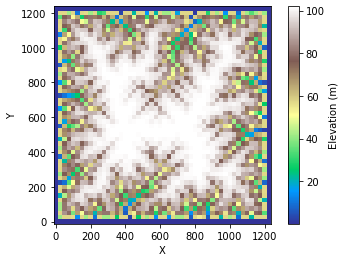

0.40 of model run completed


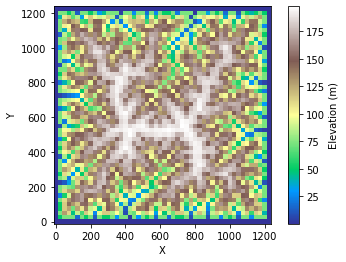

0.60 of model run completed


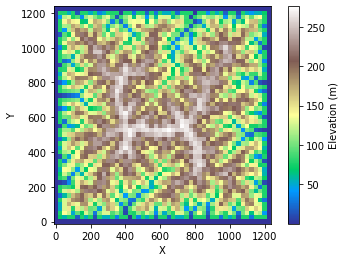

0.80 of model run completed


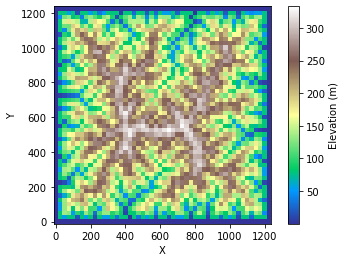

1.00 of model run completed


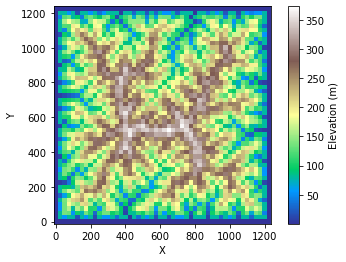

In [8]:
# Set model timestep
timestep = 1e3 #years

# Set elaspsed time to zero
elapsed_time = 0.0 #years

# Set timestep count to zero
count = 0

# Set model run time
run_time = 5e5 #years

# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))

# Uplift rate in m/yr
U = 1e-3

cmap = copy.copy(mpl.cm.get_cmap("terrain"))

while elapsed_time < run_time:  # time units of years
    # Insert uplift at core nodes
    grid.at_node["bedrock__elevation"][grid.core_nodes] += U * timestep
    grid.at_node["topographic__elevation"][:] = (
        grid.at_node["bedrock__elevation"] + grid.at_node["soil__depth"]
    )

    # Run the flow router
    flow_router.run_one_step()

    # Run SPACE for one time step
    space.run_one_step(dt=timestep)

    # Add to value of elapsed time
    elapsed_time += timestep

    if np.mod(elapsed_time, 1e5) == 0:
        print("%.2f of model run completed" % (elapsed_time / run_time))
        plt.figure()
        imshow_grid(
            grid, "topographic__elevation", cmap=cmap, colorbar_label="Elevation (m)"
        )
        plt.show()

/tmp/ipykernel_368/2583438960.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("terrain"))


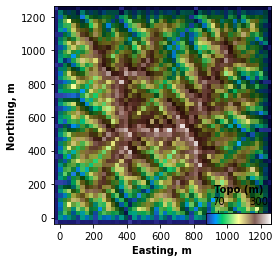

/tmp/ipykernel_368/2583438960.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("pink"))


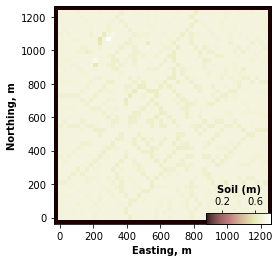

In [9]:
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
# Show DEM draped over the shaded topographic relief
imshowhs_grid(
    grid,
    "topographic__elevation",
    var_name="Topo",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)
plt.show()
# Show Soil thickness draped over the shaded topographic relief
cmap = copy.copy(mpl.cm.get_cmap("pink"))
imshowhs_grid(
    grid,
    "topographic__elevation",
    drape1=grid.at_node["soil__depth"],
    plot_type="Drape1",
    var_name="Soil",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)

z_before_LS = np.array(grid["node"]["topographic__elevation"])